# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 2**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1EjuztcsVONI_UWWTJYIVvREiDHGSxduE?usp=sharing)


[**Ссылка на техническую документацию**](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ru)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения по заданному условию (Conditional Generative Adversarial Nets (CGAN)). 

(На вход генератора подается вектор случайного шума и метка класса - на выходе должно получиться изображение, соответствующее данному классу)

Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

Взят датасет отсюда:
https://www.kaggle.com/datasets/vimpigro/handwritten-mongolian-cyrillic-characters-database

In [1]:
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint


from keras.optimizers import Adam
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

import numpy as np

import cv2

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
X_train = np.load('./food_images.npy')
Y_train = np.load('./food_images_labels.npy')

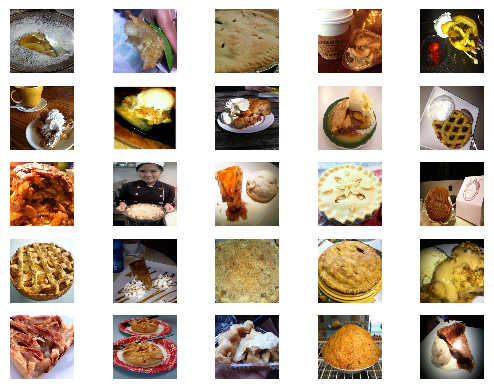

In [3]:
# plot 25 images
for epoch_num in range(25):
	plt.subplot(5, 5, 1 + epoch_num)
	plt.axis('off')
	plt.imshow(cv2.cvtColor(X_train[epoch_num], cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
def define_discriminator(in_shape=(64, 64, 3), n_classes=101):
	
    # Входная метка класса
	in_label = Input(shape=(1,))
    #Каждая метка (всего 10 классов для cifar) будет представлена вектором размера 50. 
    #Этот вектор размера 50 будет изучаться дискриминатором.
	li = Embedding(n_classes, 200)(in_label) #Shape = 1,200 (https://keras.io/api/layers/core_layers/embedding/)
	# масштабирование до размеров изображения
	n_nodes = in_shape[0] * in_shape[1]  #64x64 = 4096. 
	li = Dense(n_nodes)(li)  #Shape = 1, 4096
	# изменим форму с добавлением канала
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #64x64x1
    
    
	# Входное изображение
	in_image = Input(shape=in_shape) #64x64x3
  	# Добавляем метку класса в качестве последнего канала
	merge = Concatenate()([in_image, li]) #64x64x4 (4 канала, 3 для изображения и четвертый для метки класса)
    
	# понижение дискретизации: Эта часть аналогична GAN из прошлой работы до выходного слоя.
  	# Мы объединим входную метку с входным изображением и подадим их на вход модели. 	
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(merge) #32x32x256
	fe = LeakyReLU(alpha=0.2)(fe)
	# понижение дискретизации
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# понижение дискретизации
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# выровненная карта признаков
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# Комбинируем входную метку с входным изображением и подаем в качестве входных данных в модель.  
	model = Model([in_image, in_label], out_layer)
	# Компилируем модель
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       20200       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 4096)      823296      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                              

In [5]:
def define_generator(latent_dim, n_classes=101):
    
	# Входная метка класса
	in_label = Input(shape=(1,))  #Вход размерности 1
	#Каждая метка (всего 101 классов для cifar), будет представлена вектором размером 101. 
	li = Embedding(n_classes, 200)(in_label) #Shape 1,200
    
	# линейное умножение
	n_nodes = 16 * 16  # Чтобы сопоставить размеры для конкатенации позже   
	li = Dense(n_nodes)(li) #1,256
	# изменим форму с добавлением канала
	li = Reshape((16, 16, 1))(li)
    
    
	# входной слой генератора изображений
	in_lat = Input(shape=(latent_dim,))  #Вход размером 200
    
	# Пусть базовое изображение будет иметь размерность 16x16
    # Для этого необходимо преобразовать входной латентный вектор в изображение 16x16
    # Таким образом, значение n_nodes для полносвязного слоя может быть 32768 (128*16*16) 
    # это позволит нам преобразовать его в "изображение" с размерностью 16x16x128
    # которое мы постепенно будем "увеличивать" до размерности 32x32х3 для вывода.
    #При определении входов модели мы объединим входную метку и латентный вход.

	n_nodes = 128 * 16 * 16
	gen = Dense(n_nodes)(in_lat)  #shape=32768
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((16, 16, 128))(gen) #Shape=8x8x128
	# объединяем входные данные изображения и соответствующей ему метки класса
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Дополнительный канал соответствующий метке класса)
	# увеличиваем дискретизацию до 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# увеличиваем дискретизацию до 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# Выходной слой
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
  # определяем модель
	model = Model([in_lat, in_label], out_layer)
	return model   #Модель не компилируется, поскольку она не обучается напрямую, как дискриминатор.

test_gen = define_generator(200, 101)
print(test_gen.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32768)        6586368     ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       20200       ['input_3[0][0]']                
                                                                                            

In [7]:
def define_gan(g_model, d_model):
  d_model.trainable = False  # Дискриминатор обучается отдельно, поэтому делаем его необучаемым.
    
    ## соединяем генератор и дискриминатор
	# сначала получаем входные данные - вектор шума и метки из модели генератора
  gen_noise, gen_label = g_model.input 
	# получение выходного изображения из модели генератора
  gen_output = g_model.output  #64x64x3
    
  # выходное изображение генератора и соответствующая входная метка являются входами для дискриминатора
  gan_output = d_model([gen_output, gen_label])
	# определим gan-модель как модель принимающую на вход вектор шума и метку класса (для генератора), и выдающую значение классификатора дискриминатора
  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [8]:
def generate_real_samples(dataset, n_samples):
	# разделяем изображения и метки
  images, labels = dataset  
	# выбираем случайные экземпляры
  ix = randint(0, images.shape[0], n_samples)
	# выбераем изображения и метки
  X, labels = images[ix], labels[ix]
  # генерируем метки классов и присваиваем их переменной y 
  #  (не путайте с вышеуказанными метками, которые соответствуют меткам cifar)	
  y = ones((n_samples, 1))  #Label=1 идентифицирует о том, что изображение реальное
  return [X, labels], y

In [9]:
# загружаем изображения из датасета cifar10
def load_real_samples(trainX, trainY):

	X = trainX.astype('float32')
	# нормализуем значения из начального диапазона [0,255] в диапазон [-1,1]
	X = (X - 127.5) / 127.5   # в генераторе используется функция активации tanh, поэтому изменяем масштаб 
                            #исходных изображения в диапазон от -1 до 1.
	return [X, trainY]

In [10]:
def generate_latent_points(latent_dim, n_samples, n_classes=101):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [11]:
# Для генерации случайного шума используется функция, описанная выше 
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input], verbose=0)
	y = zeros((n_samples, 1))  #Label=0 указывает на то, что они поддельные
	return [images, labels_input], y

In [12]:
from tensorflow.keras.models import load_model, save_model
from pathlib import Path

models_path = r'model'
gan_path = models_path + '\\' + "gan_2"
generator_path = models_path + '\\' + "generator_2"
discriminator_path = models_path + '\\' + "discriminator_2"

Path(gan_path).mkdir(parents=True, exist_ok=True)
Path(generator_path).mkdir(parents=True, exist_ok=True)
Path(discriminator_path).mkdir(parents=True, exist_ok=True)

def save(gan, generator, discriminator):
    save_model(gan, gan_path)
    save_model(generator, generator_path)
    save_model(discriminator, discriminator_path)

def load(show_summary=False):
    d_model = load_model(discriminator_path)
    print('d_model loaded')
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    
    g_model = load_model(generator_path)
    print('g_model loaded')
    
    gan_model = load_model(gan_path)
    print('gan_model loaded')
    gan_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    if (show_summary):
        d_model.summary()
        g_model.summary()
        gan_model.summary()

    return gan_model, g_model, d_model

In [68]:
def save_images(g_model, epoch, show_fig=False):
	# генерируем набор случайных векторов и меток классов
	latent_points, labels = generate_latent_points(100, 100)

	# задаём метки классов - генерируем 10 наборов меток, 
	# каждая из которых имеет значение от 0 до 9
	labels = asarray([x for _ in range(10) for x in range(10)])

	# Генерируем изображения
	X  = g_model.predict([latent_points, labels])

	# Преобразуем значения каждого пикселя в диапазон [0, 255] из диапазона [-1,1]
	X = (X + 1) / 2.0
	X = (X * 255).astype(np.uint8)

	
	fig, axs = plt.subplots(10, 10)
	cnt = 0
	for i in range(10):
		for j in range(10):
			img = cv2.cvtColor(X[cnt], cv2.COLOR_BGR2RGB)
			axs[i,j].imshow(img)
			axs[i,j].axis('off')
			cnt += 1
    
	fig.savefig(f'epoch_{epoch}.png', dpi = 300)
	
	if show_fig:
		fig.show()

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=512, save_period=10, pict_gen_period=1):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #модель дискриминатора обновляется для половины партии реальных образцов 
                            #и половины партии поддельных образцов, объединенных в одну партию.  
	
	epoch_progress = tqdm(total=n_epochs)
	batch_progress = tqdm(total=bat_per_epo)
	
	for epoch_num in range(n_epochs): 
		for batch_num in range(bat_per_epo):
	      	# Обучаем дискриминатор на реальных и поддельных изображениях, отдельно (по половине партии каждого).
      		# Исследования показали, что раздельное обучение более эффективно. 
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      		# обновление весов модели дискриминатора
      		# train_on_batch позволяет обновлять веса на основе коллекции предоставляемых образцов
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# генерируем поддельные примеры
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# обновляем веса модели дискриминатора
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            
			# генерация вектором случайного шума для нужного числа экземпляров в качестве входных данных для генератора
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
        	# Генератор хочет, чтобы дискриминатор пометил сгенерированные образцы
        	# как истинные (единицы)
        	# Здесь генератор пытается обмануть дискриминатор, чтобы тот поверил.
        	# что сгенерированное изображение истинно (отсюда значение 1 для y)	
			# поэтому для поддельных образцов мы создаём инвертированные метки 
			y_gan = ones((n_batch, 1))
   
        	# Генератор является частью комбинированной модели, где он напрямую связан с дискриминатором.
        	# Обучите генератор с latent_dim в качестве x и 1 в качестве y. 
        	# Опять же, 1 в качестве выхода, так как он является состязательным, и если генератор отлично справился со своей задачей.
        	# работу по следованию дискриминатору, то на выходе будет 1 (true)
			# обновить генератор через ошибку дискриминатора
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

			# Выводим потери по этой партии
			status = 'Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch_num+1, batch_num+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)
			batch_progress.set_description_str(status)
			batch_progress.update(1)
		

		if (epoch_num % save_period == 0):
			save(gan_model, g_model, d_model)

		if (epoch_num % pict_gen_period == 0):
			save_images(g_model, epoch_num)

		epoch_progress.update(1)
		batch_progress.reset()

In [18]:
# Размерность вектора случайного шума
latent_dim = 200

In [19]:
# создание модели дискриминатора
d_model = define_discriminator()
# создание модели генератора
g_model = define_generator(latent_dim)
# создание комбинированной модели GAN
gan_model = define_gan(g_model, d_model)

In [114]:
gan_model, g_model, d_model = load()

d_model loaded


g_model loaded
gan_model loaded


In [ ]:
# загрузка датасета
dataset = load_real_samples(X_train, Y_train)

# обучение модели
train(
    g_model, 
    d_model, 
    gan_model, 
    dataset, 
    latent_dim, 
    n_epochs=10,
    n_batch=256,
    save_period=1,
    pict_gen_period=1
)

### Демонстрация сгенерированных изображений:

In [33]:
# сохранение обученной модели генератора (без возможности дообучения)
g_model.save('food_conditional_generator_30epochs.h5')

In [14]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [34]:
g_model = load_model('./food_conditional_generator_30epochs.h5')

4/4 [==============================] - 0s 23ms/step


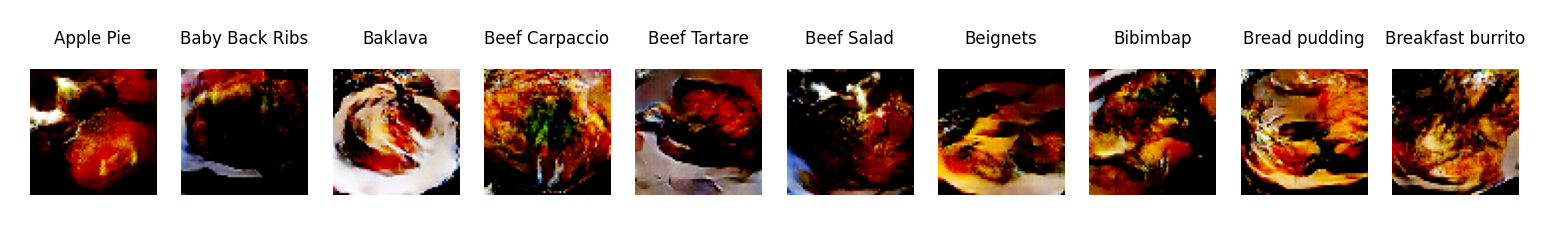

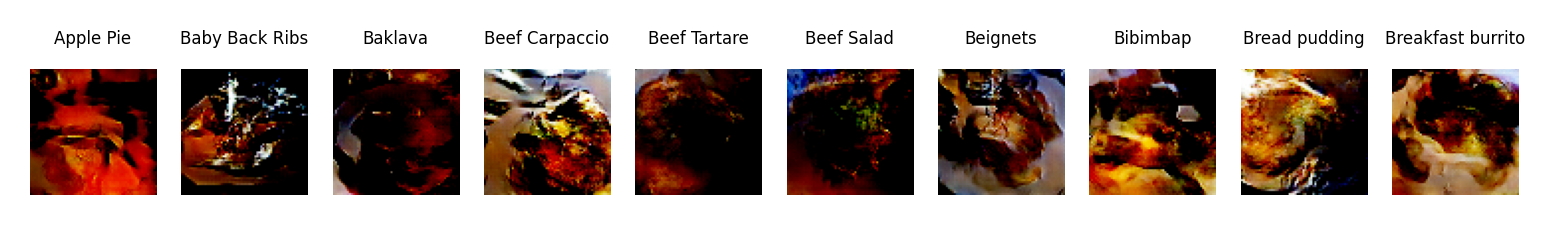

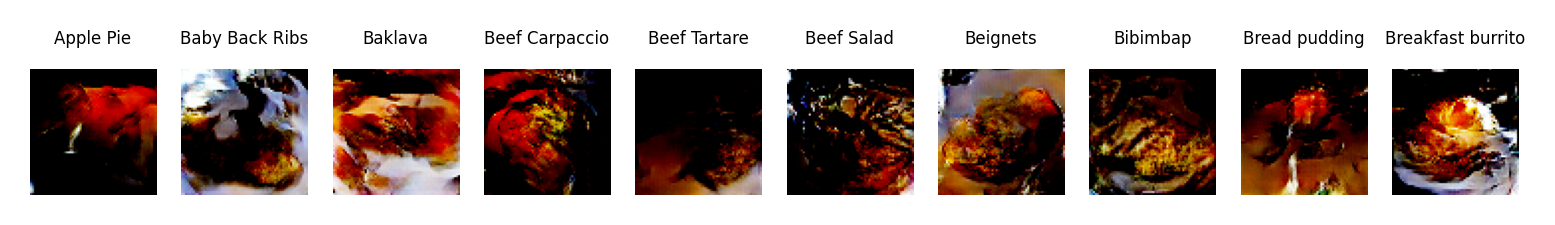

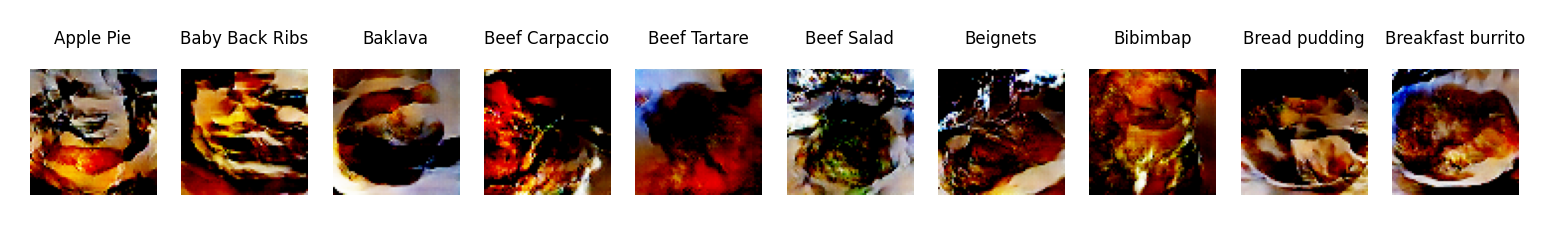

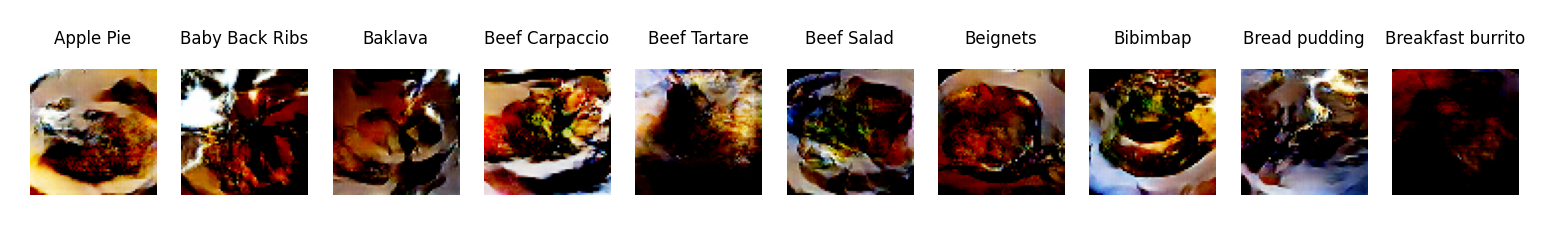

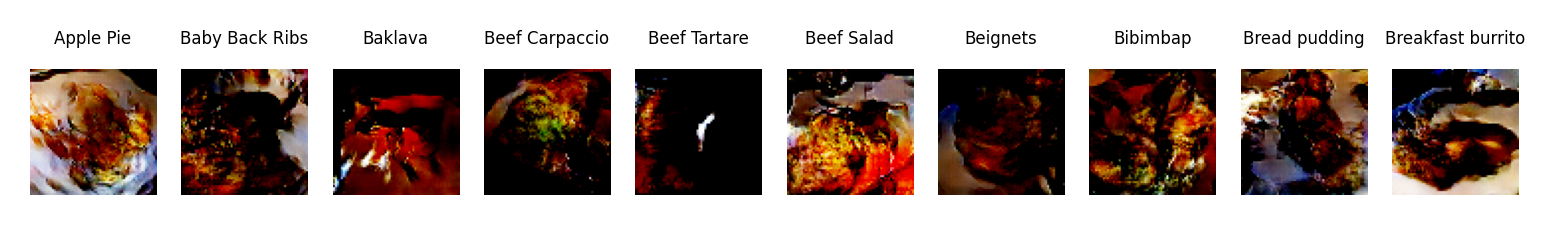

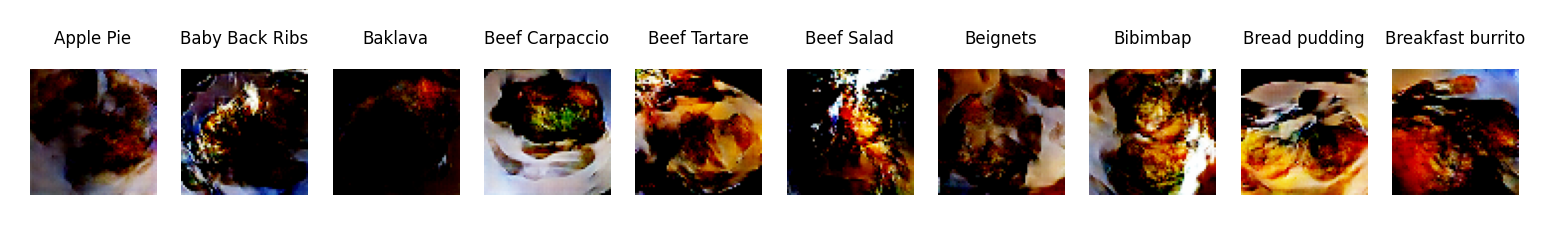

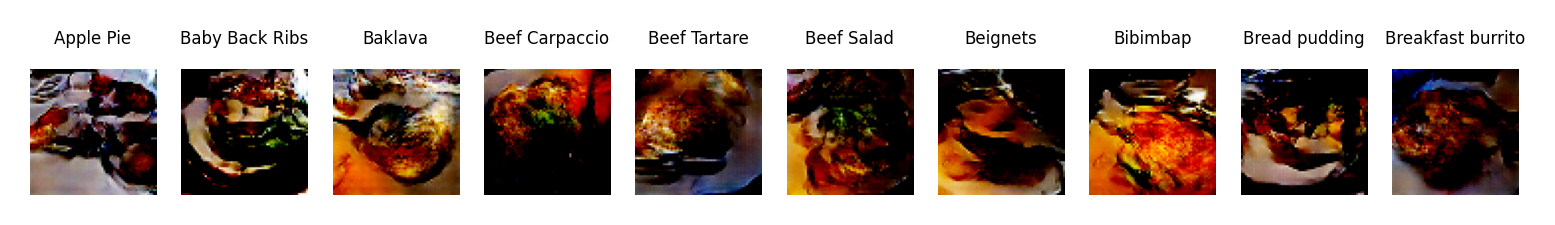

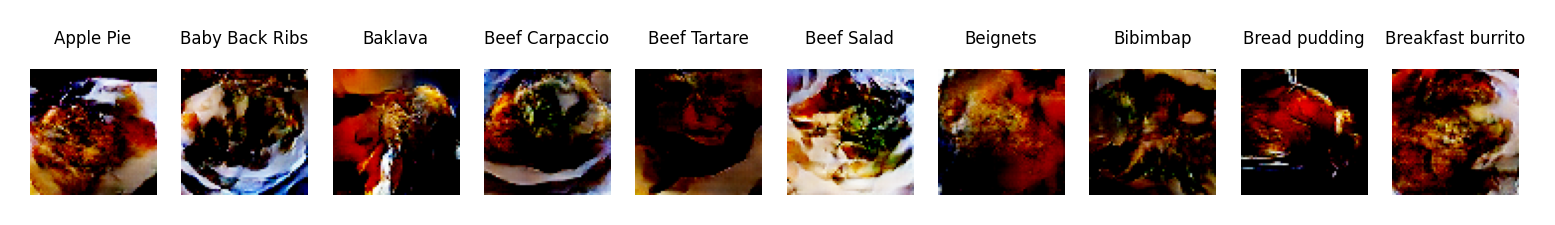

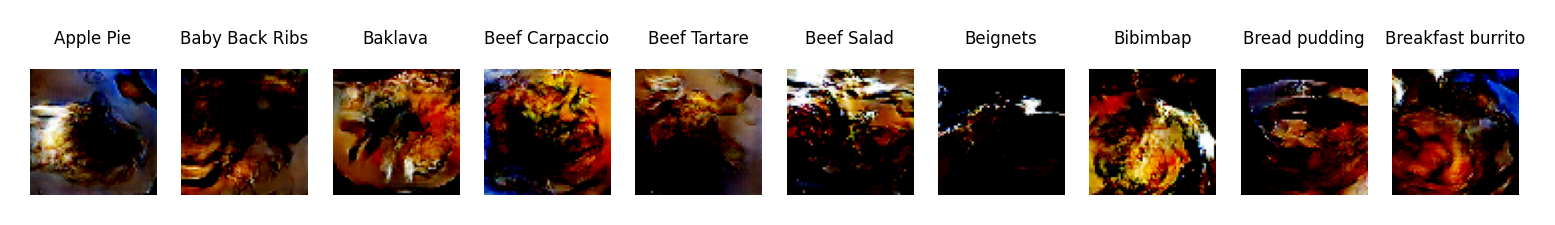

In [67]:
latent_points, labels = generate_latent_points(200, 100)
labels = asarray([x for _ in range(10) for x in range(10)])

label_desc = {
    0: 'Apple Pie',
    1: 'Baby Back Ribs',
    2: 'Baklava',
    3: 'Beef Carpaccio',
    4: 'Beef Tartare',
    5: 'Beef Salad',
    6: 'Beignets',
    7: 'Bibimbap',
    8: 'Bread pudding',
    9: 'Breakfast burrito'
}

# Генерируем изображения
X = g_model.predict([latent_points, labels])

cnt = 0
for i in range(10):
    fig, axs = plt.subplots(1, 10, dpi=300)
    for j in range(10):
        img = cv2.cvtColor(X[cnt], cv2.COLOR_BGR2RGB)
        axs[j].imshow(img)
        axs[j].set_title(label_desc[j], fontsize=4)
        axs[j].axis('off')
        cnt += 1	
    fig.show()

# **Задание №2.** Обучите генератор воспризводить **спутниковый снимок** по **загруженной маске** (pix2pix). Используйте для этого разделенный на патчи датасет из практической работы №7 ([Ссылка на датасет](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery))

In [32]:
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint


from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Activation, LeakyReLU, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal

import numpy as np
from numpy import vstack

from matplotlib import pyplot

import time
import cv2
from tqdm.notebook import tqdm

In [11]:
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)

In [8]:
dataset = [np.load('./landcover_images.npy'), np.load('./landcover_masks.npy')]

In [9]:
print(dataset[0].shape)
print(dataset[1].shape)

(411, 256, 256, 3)
(411, 256, 256, 3)


In [3]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2),
               padding='same', kernel_initializer=init)(layer_in)

    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [4]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)

    if dropout:
        g = Dropout(0.5)(g, training=True)

    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g


In [5]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    input_image_shape = Input(shape=image_shape)

    target_image_shape = Input(shape=image_shape)

    merged = Concatenate()([input_image_shape, target_image_shape])

    # conv block-1
    dis_model = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-2
    dis_model = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-3
    dis_model = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-4
    dis_model = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-5
    dis_model = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-6
    dis_model = Conv2D(1, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    patch_out = Activation('sigmoid')(dis_model)

    model = Model(([input_image_shape, target_image_shape]), patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    model.summary()

    return model

In [6]:
def define_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    input_image = Input(shape=image_shape)

    # encoder model
    e1 = encoder_block(input_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    # bottleneck , no batch norm and relu
    bottleneck = Conv2D(512, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(e7)
    bottleneck = Activation('relu')(bottleneck)

    # decoder model
    d1 = decoder_block(bottleneck, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(d7)

    output_image = Activation('tanh')(g)
    model = Model(input_image, output_image)
    model.summary()

    return model

In [7]:
def gan(gen_model, dis_model, image_shape):
    dis_model.trainable = False

    input_src_image = Input(shape=image_shape)

    gen_output_image = gen_model(input_src_image)
    # fed source input image and generator output
    # to discriminator model
    dis_output_image = dis_model([input_src_image, gen_output_image])

    model = Model(input_src_image, [dis_output_image, gen_output_image])

    opt = Adam(lr=0.0002, beta_1=0.5)

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

#### Генератор набора реальных изображений

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    index = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[index], trainB[index]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

#### Генератор набора "поддельных" изображений

In [26]:
def generate_fake_samples(gen_model, samples, patch_shape):
    X = gen_model.predict(samples, verbose=0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

#### Функция для проверки генератора и визуализации его работы, а также сохранение модели. 

In [18]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
        
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
        
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
        
    filename1 = 'plot_%06d.png' % (step + 1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'data/'+'model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print(' > Saved: % s and % s' % (filename1, filename2))


#### Обучение

In [24]:
def train(dis_model, gen_model, gan_model, dataset, n_epochs=40, n_batch=1):
    n_patch = dis_model.output_shape[1]
    trainA, trainB = dataset
    batch_per_epoch = int(len(trainA) / n_batch)
    n_steps = batch_per_epoch * n_epochs

    progress = tqdm(total=n_steps)
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(gen_model, X_realA, n_patch)
        d_loss1 = dis_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = dis_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        status = '>%d/%d ,d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1 , n_steps, d_loss1, d_loss2, g_loss)
        progress.set_description_str(status)
        progress.update(1)

        if (i + 1) % (batch_per_epoch * 10) == 0:
            summarize_performance(i, gen_model, dataset)

In [27]:
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, dataset)
start_time = time.time()
print('-----%s seconds-----'%(time.time() - start_time))


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_16 (Concatenate)   (None, 256, 256, 6)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

c:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 64  3136        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_29 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_34[0][0]']              
                                )                                                           

  0%|          | 0/16440 [00:00<?, ?it/s]

 > Saved: plot_004110.png and data/model_004110.h5
 > Saved: plot_008220.png and data/model_008220.h5
 > Saved: plot_012330.png and data/model_012330.h5
 > Saved: plot_016440.png and data/model_016440.h5
-----0.0 seconds-----


In [28]:
g_model.save('landcover_40epochs.h5')

### Демонстрация сгенерированных изображений:

In [29]:
model = load_model('landcover_40epochs.h5')

c:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [30]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 1s 551ms/step


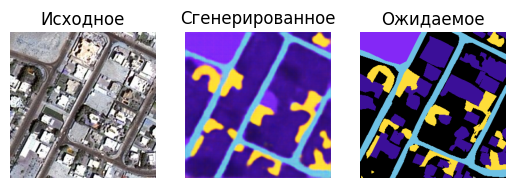

1/1 [==============================] - 0s 35ms/step


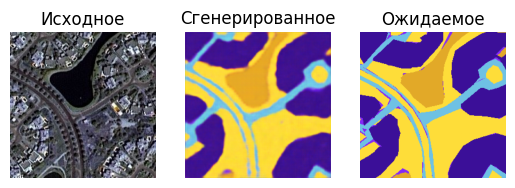

1/1 [==============================] - 0s 40ms/step


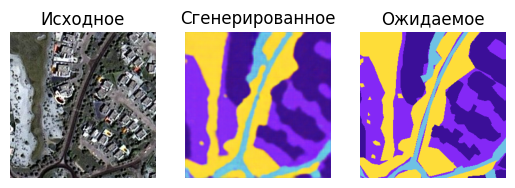

1/1 [==============================] - 0s 43ms/step


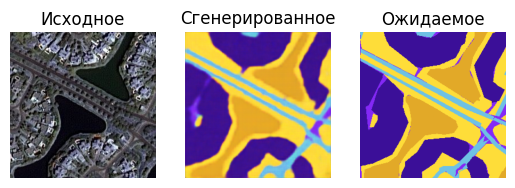

1/1 [==============================] - 0s 41ms/step


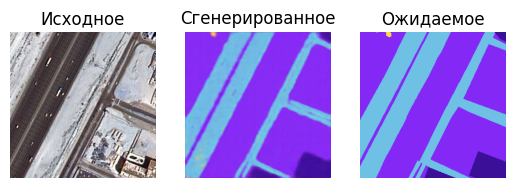

1/1 [==============================] - 0s 37ms/step


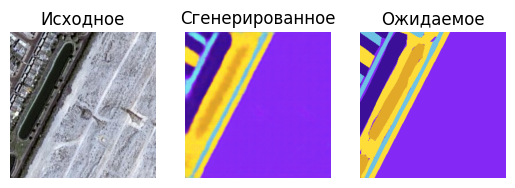

1/1 [==============================] - 0s 37ms/step


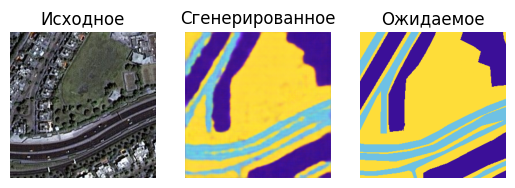

1/1 [==============================] - 0s 39ms/step


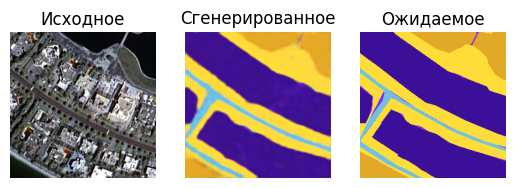

1/1 [==============================] - 0s 39ms/step


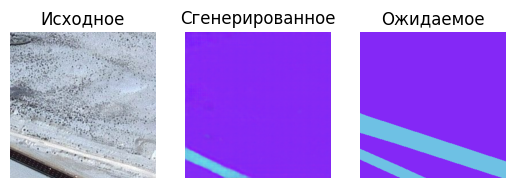

1/1 [==============================] - 0s 41ms/step


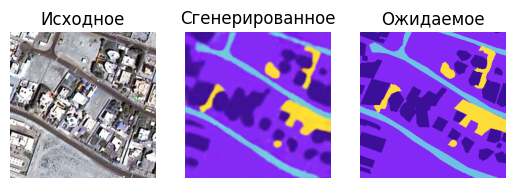

In [33]:
[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту

# **Задание №3.** Обучите генератор воспроизводить изображения из выбранного Вами датасета (pix2pix). 

Датасет может быть сформирован Вами (например, черно-белые и цветные изображения) или найден в глобальной сети Интернет. 

Например [тут](https://www.kaggle.com/search?q=pix2pix+in%3Adatasets+datasetFileTypes%3Ajpg+datasetFileTypes%3Apng) или [тут](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

In [1]:
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint


from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Activation, LeakyReLU, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal

import numpy as np
from numpy import vstack

from matplotlib import pyplot

import time
import cv2
from tqdm.notebook import tqdm

In [2]:
dataset = [np.load('./faces_images.npy')[:5000], np.load('./comic_images.npy')[:5000]]

In [3]:
print(dataset[0].shape)
print(dataset[1].shape)

(5000, 256, 256, 3)
(5000, 256, 256, 3)


In [5]:
print(dataset[0].shape)
print(dataset[1].shape)

(10000, 256, 256, 3)
(10000, 256, 256, 3)


In [4]:
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)

In [5]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2),
               padding='same', kernel_initializer=init)(layer_in)

    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [6]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)

    if dropout:
        g = Dropout(0.5)(g, training=True)

    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g


In [7]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    input_image_shape = Input(shape=image_shape)

    target_image_shape = Input(shape=image_shape)

    merged = Concatenate()([input_image_shape, target_image_shape])

    # conv block-1
    dis_model = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-2
    dis_model = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-3
    dis_model = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-4
    dis_model = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-5
    dis_model = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(dis_model)
    dis_model = BatchNormalization()(dis_model)
    dis_model = LeakyReLU(alpha=0.2)(dis_model)

    # conv block-6
    dis_model = Conv2D(1, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(dis_model)
    patch_out = Activation('sigmoid')(dis_model)

    model = Model(([input_image_shape, target_image_shape]), patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    model.summary()

    return model

In [8]:
def define_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    input_image = Input(shape=image_shape)

    # encoder model
    e1 = encoder_block(input_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    # bottleneck , no batch norm and relu
    bottleneck = Conv2D(512, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(e7)
    bottleneck = Activation('relu')(bottleneck)

    # decoder model
    d1 = decoder_block(bottleneck, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2),
                        padding='same', kernel_initializer=init)(d7)

    output_image = Activation('tanh')(g)
    model = Model(input_image, output_image)
    model.summary()

    return model

In [9]:
def gan(gen_model, dis_model, image_shape):
    dis_model.trainable = False

    input_src_image = Input(shape=image_shape)

    gen_output_image = gen_model(input_src_image)
    # fed source input image and generator output
    # to discriminator model
    dis_output_image = dis_model([input_src_image, gen_output_image])

    model = Model(input_src_image, [dis_output_image, gen_output_image])

    opt = Adam(lr=0.0002, beta_1=0.5)

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

In [10]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    index = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[index], trainB[index]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [11]:
def generate_fake_samples(gen_model, samples, patch_shape):
    X = gen_model.predict(samples, verbose=0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [12]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
        
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
        
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
        
    filename1 = 'plot_%06d.png' % (step + 1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'data/'+'model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print(' > Saved: % s and % s' % (filename1, filename2))


In [13]:
def train(dis_model, gen_model, gan_model, dataset, n_epochs=10, n_batch=1):
    n_patch = dis_model.output_shape[1]
    trainA, trainB = dataset
    batch_per_epoch = int(len(trainA) / n_batch)
    n_steps = batch_per_epoch * n_epochs

    progress = tqdm(total=n_steps)
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(gen_model, X_realA, n_patch)
        d_loss1 = dis_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = dis_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        status = '>%d/%d ,d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1 , n_steps, d_loss1, d_loss2, g_loss)
        progress.set_description_str(status)
        progress.update(1)

        if (i + 1) % (batch_per_epoch * 10) == 0:
            summarize_performance(i, gen_model, dataset)

In [ ]:
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = gan(g_model, d_model, image_shape)

In [14]:
train(d_model, g_model, gan_model, dataset)
start_time = time.time()
print('-----%s seconds-----'%(time.time() - start_time))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

c:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_2[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 512)  4194816     ['leaky_re_lu_3[0][0]']          
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_3[0][0]']  
          

  0%|          | 0/50000 [00:00<?, ?it/s]

 > Saved: plot_050000.png and data/model_050000.h5
-----0.0 seconds-----


In [15]:
g_model.save('face2comics_10epochs.h5')

### Демонстрация сгенерированных изображений:

In [16]:
model = load_model('face2comics_10epochs.h5')

In [17]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 1s 714ms/step


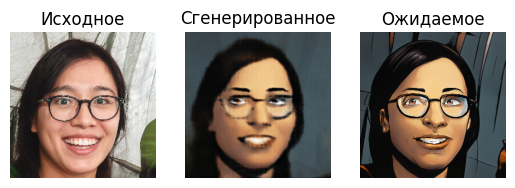

1/1 [==============================] - 0s 39ms/step


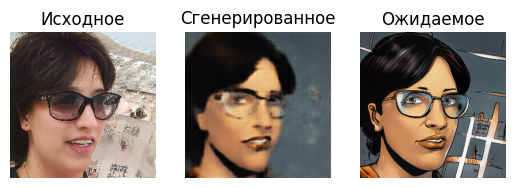

1/1 [==============================] - 0s 50ms/step


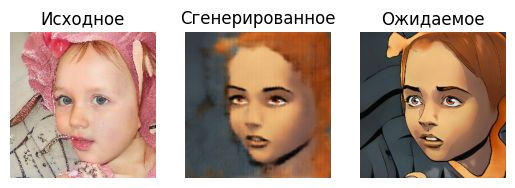

1/1 [==============================] - 0s 48ms/step


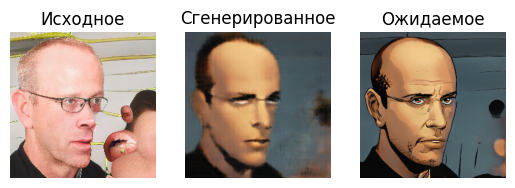

1/1 [==============================] - 0s 51ms/step


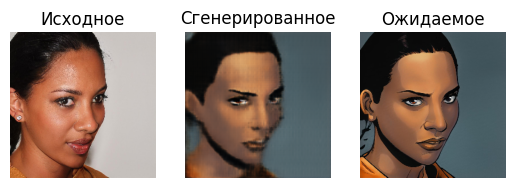

1/1 [==============================] - 0s 48ms/step


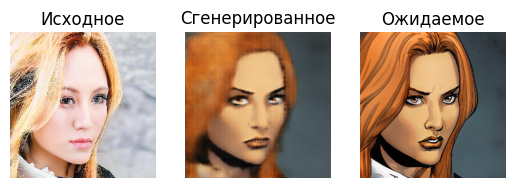

1/1 [==============================] - 0s 50ms/step


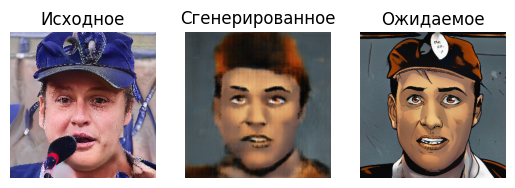

1/1 [==============================] - 0s 47ms/step


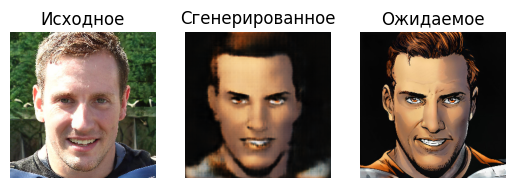

1/1 [==============================] - 0s 54ms/step


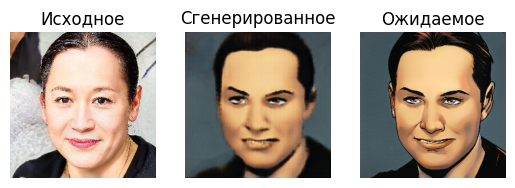

1/1 [==============================] - 0s 60ms/step


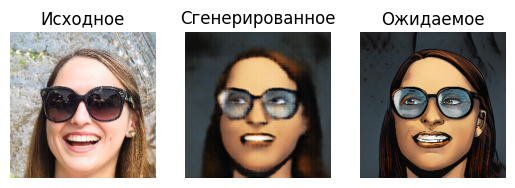

In [18]:
[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту